In [1]:
# =================================================================
# 1. SETUP & LOAD DATA
# =================================================================
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive



In [5]:
# csv load
file_path = '/content/drive/MyDrive/Blockchain/FINAL_MAJOR_project/agb/AGB_Samples_NE_India_2020_FULL_FEATURE_SET.csv'
df = pd.read_csv(file_path)

print(f"Original Data Size: {len(df)} rows")




Original Data Size: 9071 rows


In [6]:
# SAFETY CHECK: Even though we want 0s, we cannot have "NaN" (Empty/Null).
# This line keeps the 0s (Cities/Water) but removes broken rows.
df_clean = df.dropna()

print(f"Original size: {len(df)}")
print(f"Final size for training: {len(df_clean)}")

Original size: 9071
Final size for training: 9071


In [7]:
# =================================================================
# 3. DEFINE FEATURES (X) AND TARGET (y)
# =================================================================

feature_cols = [
    'latitude', 'longitude',    # <--- Location is CRITICAL for high accuracy
    'height',                   # Structure
    'VV', 'VH', 'VH_ent', 'VH_var', # Radar
    'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', # Optical
    'NDVI', 'NDVI_sigma',       # Vegetation Indices
    'elevation', 'slope'        # Terrain
]

X = df_clean[feature_cols]
y = df_clean['agb']


In [8]:
# =================================================================
# 4. SPLIT TRAINING & TESTING DATA
# =================================================================
# 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [9]:
# =================================================================
# 5. TRAIN XGBOOST MODEL
# =================================================================

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    random_state=42,
    n_jobs=-1
)
print("Training Model...")
model.fit(X_train, y_train)
print("Training Complete!")




Training Model...
Training Complete!


In [13]:
# =================================================================
# 6. EVALUATE PERFORMANCE
# =================================================================

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"New R² Score with Location: {r2:.4f}")

# Calculate Metrics

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5

print("-" * 30)
print(f"Model Performance:")
print(f"RMSE: {rmse:.2f} tonnes/ha ")
print(f"R² Score: {r2:.4f}")
print("-" * 30)

New R² Score with Location: 0.7381
------------------------------
Model Performance:
RMSE: 48.69 tonnes/ha 
R² Score: 0.7381
------------------------------


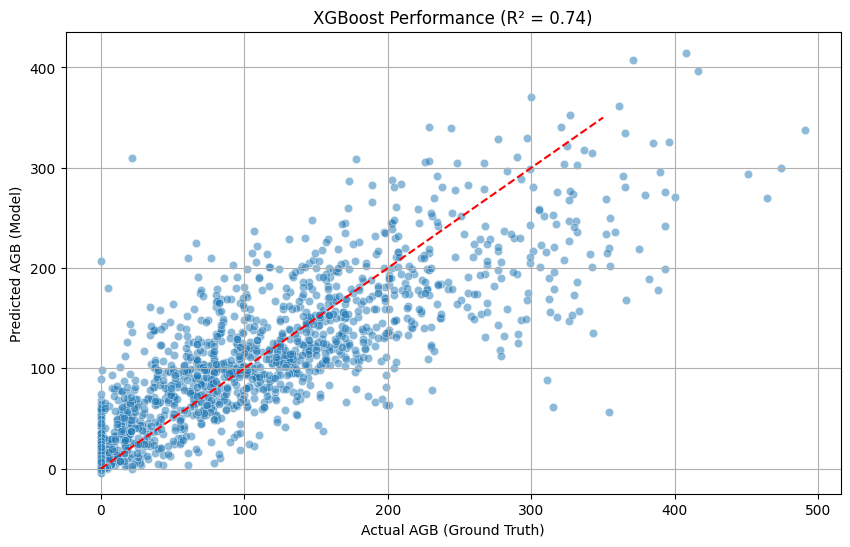

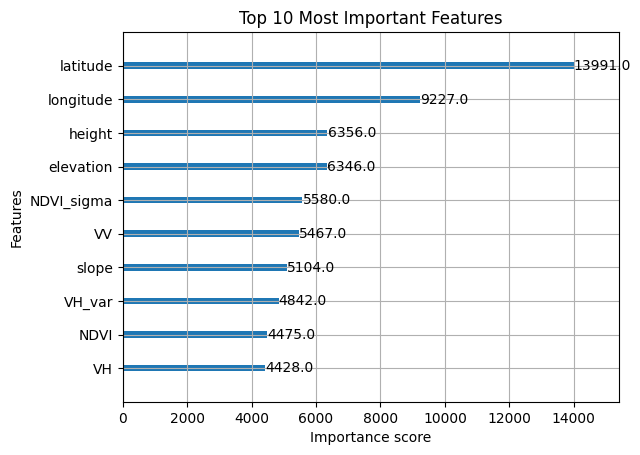

In [11]:
# =================================================================
# 7. VISUALIZE RESULTS
# =================================================================
plt.figure(figsize=(10, 6))

# Plot Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([0, 350], [0, 350], color='red', linestyle='--') # Perfect prediction line

plt.xlabel('Actual AGB (Ground Truth)')
plt.ylabel('Predicted AGB (Model)')
plt.title(f'XGBoost Performance (R² = {r2:.2f})')
plt.grid(True)
plt.show()

# Plot Feature Importance (What mattered most?)
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Most Important Features")
plt.show()

In [12]:
# =================================================================
# UPLOAD UPDATED MODEL — VERSION 2 (R2 = 0.77)
# =================================================================

from huggingface_hub import HfApi, login

# 1. Login (write token)
login(token="")

# 2. Save the NEW model as Version 2
final_filename = "agb_prediction_model_ne_india_v2.json"
model.save_model(final_filename)
print(f"Final model (v2) saved locally as: {final_filename}")

# 3. Hugging Face Repo (already exists)
api = HfApi()
repo_id = "mona0125/agb-biomass-estimation-ne-india"

# 4. Upload Version 2
print("Uploading Model Version 2 (R2 = 0.77)...")
api.upload_file(
    path_or_fileobj=final_filename,
    path_in_repo=final_filename,
    repo_id=repo_id,
    repo_type="model",
    commit_message="v2: Updated AGB model trained on full land-cover spectrum (R2 = 0.77)"
)

print("---------------------------------------------------------")
print("SUCCESS! Version 2 is live.")
print(f"Repo: https://huggingface.co/{repo_id}")
print("---------------------------------------------------------")


Final model (v2) saved locally as: agb_prediction_model_ne_india_v2.json
Uploading Model Version 2 (R2 = 0.77)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


---------------------------------------------------------
SUCCESS! Version 2 is live.
Repo: https://huggingface.co/mona0125/agb-biomass-estimation-ne-india
---------------------------------------------------------
